# Expectation Propagation

ReactiveMP comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable $x_t$ with the discrete variable $y_t$. The model is defined as:

\begin{align}
    u &= 0.1 \\
    x_0 &\sim \mathcal{N}(0, 100) \\
    x_t &\sim \mathcal{N}(x_{t-1}+ u, 0.01) \\
    y_t &\sim \mathrm{Ber}(\Phi(x_t))
\end{align}

## Import packages

In [1]:
using StatsFuns: normcdf
using Random, PyPlot

using ReactiveMP, GraphPPL, Rocket

##  Data generation

In [2]:
function generate_data(nr_samples::Int64)
    
    # hyper parameters
    u = 0.1

    # allocate space for data
    data_x = zeros(nr_samples + 1)
    data_y = zeros(nr_samples)
    
    # initialize data
    data_x[1] = -2
    
    # generate data
    for k = 2:nr_samples + 1
        
        # calculate new x
        data_x[k] = data_x[k-1] + u + sqrt(0.01)*randn()
        
        # calculate y
        data_y[k-1] = normcdf(data_x[k]) > rand()
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [3]:
n = 40

40

In [4]:
data_x, data_y = generate_data(n);

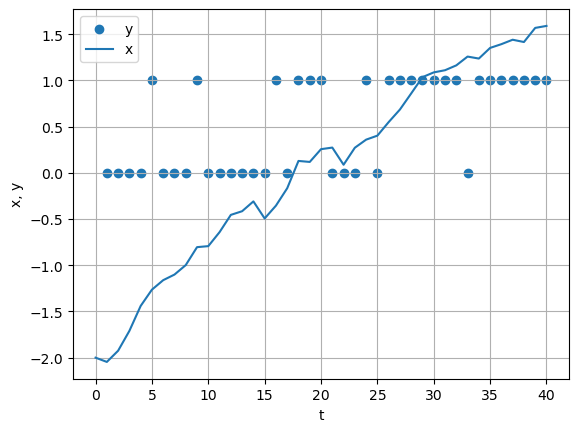

In [5]:
plt.figure()
plt.scatter(1:n, data_y, label="y")
plt.plot(data_x, label="x")
plt.xlabel("t")
plt.ylabel("x, y")
plt.legend()
plt.grid();

## Model specification

In [6]:
# TODO: check
@model function probit_model(nr_samples::Int64)
    
    # allocate space for variables
    x = randomvar(nr_samples + 1)
    y = datavar(Float64, nr_samples)
    
    # specify uninformative prior
    x[1] ~ NormalMeanPrecision(0.0, 0.01)
    
    # create model 
    for k = 2:nr_samples + 1
        x[k] ~ NormalMeanPrecision(x[k - 1] + 0.1, 100)
        y[k - 1] ~ Probit(x[k]) where {
            # Probit node by default uses RequireInbound pipeline with vague(NormalMeanPrecision) message as initial value for `in` edge
            # To change initial value use may specify it manually, like
            # pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) 
        }
    end
    
    # return parameters
    return x, y
    
end;

## Inference

In [7]:
result = inference(
    model = Model(probit_model, length(data_y)), 
    data  = (y = data_y, ), 
    iterations = 100, 
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
-----------------------------------------
x = Vector{Marginal}[[Marginal(NormalWeightedMeanPrecision{Float64}(xi=0.11998777067...


## Results

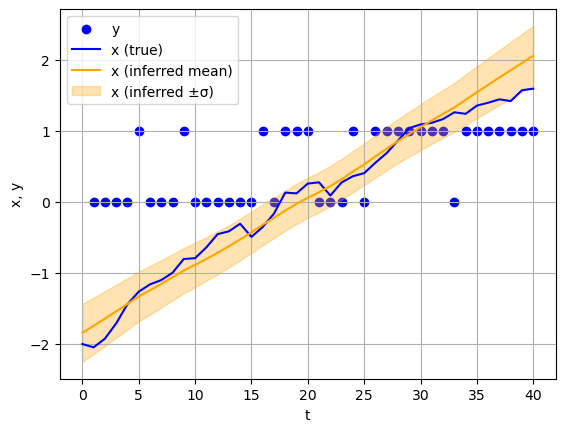

In [8]:
mx = result.posteriors[:x][end]

plt.figure()
plt.scatter(1:n, data_y, label="y", color="blue")
plt.plot(data_x, label="x (true)", color="blue")
plt.plot(mean.(mx), label="x (inferred mean)", color="orange")
plt.fill_between(0:n, mean.(mx) .- std.(mx), mean.(mx) + std.(mx), label="x (inferred ±σ)", alpha=0.3, color="orange")
plt.xlabel("t")
plt.ylabel("x, y")
plt.legend()
plt.grid();